In [1]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [2]:
# 試験ID生成
trial_prefix = 'nb012'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb012
nb012_20210529_152925


In [3]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [5]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [6]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [7]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [8]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [10]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 文章の中身を確認

In [11]:
train_base.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [13]:
# url_regal
train_base['url_legal'].unique()

array([nan, 'https://simple.wikipedia.org/wiki/Battle_of_Britain',
       'https://simple.wikipedia.org/wiki/Battle_of_Saratoga',
       'https://simple.wikipedia.org/wiki/Battle_of_Waterloo',
       'https://en.wikipedia.org/wiki/Big_data',
       'https://en.wikipedia.org/wiki/Biodiesel',
       'https://en.wikipedia.org/wiki/Biodiversity',
       'https://en.wikipedia.org/wiki/Biotechnology',
       'https://kids.frontiersin.org/article/10.3389/frym.2020.00090',
       'https://en.wikipedia.org/wiki/Bitcoin',
       'https://en.wikipedia.org/wiki/Black_hole',
       'https://en.wikipedia.org/wiki/Blockade',
       'https://simple.wikipedia.org/wiki/Blood',
       'https://simple.wikipedia.org/wiki/Bluetooth',
       'https://en.wikipedia.org/wiki/Boiling_point',
       'https://en.wikipedia.org/wiki/Boston_Tea_Party',
       'https://en.wikipedia.org/wiki/Brain_implant',
       'https://en.wikipedia.org/wiki/Broadband',
       'https://en.wikipedia.org/wiki/Broadcasting',
       'ht

- wikipediaが多そうだ。
- urlの冒頭を抽出することで、大まかに分布を確認できるかもしれない。
- ただし、NULLがどの程度存在するかは要確認。

In [16]:
# NULLどのくらい？
train_base['url_legal'].isnull().sum()/len(train_base)

0.7071277346506705

In [78]:
tmp

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                                     NaN
                              ...                        
2829    https://sites.ehe.osu.edu/beyondpenguins/files...
2830    https://en.wikibooks.org/wiki/Wikijunior:The_E...
2831    https://en.wikibooks.org/wiki/Wikijunior:The_E...
2832    https://en.wikibooks.org/wiki/Geometry_for_Ele...
2833    https://en.wikibooks.org/wiki/Wikijunior:Biolo...
Name: url_legal, Length: 2834, dtype: object

In [80]:
tmp = train_base['url_legal'].copy()
tmp[tmp.isnull()] = 'nan'

tmp_2 = tmp.map(lambda x: re.match('http\w*://[^/]*/', x).group() if re.match('http\w*://[^/]*/', x) is not None else np.nan)
tmp_2[tmp_2.isnull()] = 'nan'

In [81]:
tmp_2.value_counts()

nan                                    2004
https://simple.wikipedia.org/           196
https://kids.frontiersin.org/           191
https://en.wikipedia.org/               176
https://www.africanstorybook.org/       164
https://www.commonlit.org/               41
https://www.digitallibrary.io/           19
https://freekidsbooks.org/               19
https://en.wikibooks.org/                 8
http://static.ehe.osu.edu/                6
https://drive.google.com/                 3
http://ukuqonda.co.za/                    2
https://www.ck12.org/                     2
https://beyondpenguins.ehe.osu.edu/       1
https://emedia.uen.org/                   1
https://sites.ehe.osu.edu/                1
Name: url_legal, dtype: int64

In [82]:
train_base['license'].unique()

array([nan, 'CC BY-SA 3.0 and GFDL', 'CC BY-SA 3.0', 'CC BY 4.0',
       'CC BY-NC', 'CC BY-NC-SA 2.0', 'CC BY-NC 3.0', 'CC BY-NC-ND 4.0',
       'CC BY NC-SA 2.0', 'CC BY-NC 2.0', 'CC-BY-SA', 'CC-BY-NC',
       'CC BY 3.0', 'GNU Free Document License, version 1.2',
       'CC BY-NC-SA 3.0', 'CC BY-NC-SA 4.0'], dtype=object)

In [83]:
train_base['license'].value_counts()

CC BY 4.0                                 391
CC BY-SA 3.0 and GFDL                     196
CC BY-SA 3.0                              192
CC BY-NC-SA 2.0                            26
CC BY 3.0                                   7
CC BY-NC-SA 4.0                             4
CC BY-NC-ND 4.0                             3
CC BY-NC-SA 3.0                             2
CC BY-NC                                    2
CC BY NC-SA 2.0                             2
GNU Free Document License, version 1.2      1
CC-BY-SA                                    1
CC-BY-NC                                    1
CC BY-NC 3.0                                1
CC BY-NC 2.0                                1
Name: license, dtype: int64

### 読み解き
- urlを見ると、(NULLでないものの中では)wikipediaの文書が多いようだ。
- 一方、「https://kids.frontiersin.org/ 」「https://www.africanstorybook.org/」あたりも無視できない。
  - NULLの文書の中で、類似性を見出せそうなら見出してみたい。
- ライセンスからは、ぱっと見で意味のありそうな情報は読み取れない。

### やること
- とりあえずwikipediaのgloveベクトルを使った特徴を試作してみる。
- 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1

In [178]:
import gensim
import gensim.downloader as api

model = api.load('glove-wiki-gigaword-300')

KeyboardInterrupt: 

In [186]:
gen_path = '~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300'
gen_model = gensim.models.KeyedVectors.load_word2vec_format(gen_path, binary=False)

In [187]:
gen_model['text']

array([-8.1660e-01, -2.7569e-01, -3.2951e-01, -1.9751e-01, -1.3119e-01,
        5.8965e-01, -4.7443e-01, -2.0593e-01,  3.2954e-01, -1.5815e+00,
        2.2524e-01,  1.9357e-01,  2.6813e-01,  1.8815e-01,  2.0841e-01,
       -2.0430e-01, -2.5769e-01, -9.5931e-03,  2.0479e-02, -4.1720e-01,
       -2.8133e-01, -3.9980e-01, -1.6343e-01,  5.9352e-01, -5.3312e-02,
       -7.3362e-02,  3.9872e-01, -5.3993e-02,  6.2894e-01, -4.0527e-02,
        2.0639e-01,  3.1568e-01, -6.2093e-01,  7.4989e-01, -7.9408e-01,
       -3.0658e-01,  2.5953e-01, -7.4764e-01, -2.5008e-01,  2.8804e-01,
       -1.9341e-01, -4.6537e-02, -4.7254e-01,  8.0808e-02,  4.5168e-02,
        3.5310e-01, -1.5433e-01,  2.6329e-01, -6.6062e-01, -6.3936e-01,
        4.1719e-01,  5.0924e-01,  3.0314e-01, -3.3813e-01, -1.3836e-01,
       -5.3940e-02, -2.5473e-01, -4.2587e-02,  1.0552e-01,  1.9062e-01,
        4.0879e-01,  1.8214e-01,  6.2152e-01,  6.2670e-02, -4.9173e-02,
       -1.7120e-02,  7.0203e-01, -8.6368e-02,  4.8933e-01,  3.36

In [91]:
gen_model.vector_size

300

In [110]:
type(gen_model)

gensim.models.keyedvectors.KeyedVectors

In [102]:
text = text_normalization(train_base['excerpt'])
text.head()

0    young people returned ballroom presented decid...
1    dinner time mrs fayre somewhat silent eyes res...
2    roger predicted snow departed quickly came two...
3    outside palace great garden walled round fille...
4    upon time three bears lived together house woo...
Name: excerpt, dtype: object

In [106]:
embeddings = [
    gen_model[word]
    if word in gen_model
    else np.zeros(gen_model.vector_size)
    for word in text[0].split()
]

In [109]:
len(embeddings)

89

In [111]:
def get_sentence_vector(model:gensim.models.keyedvectors.KeyedVectors, x: str):
    ndim = model.vector_size
    embeddings = [
        model[word]
        if word in model
        else np.zeros(ndim)
        for word in x.split()
    ]
    
    if len(embeddings) == 0:
        return np.zeros(ndim, dtype=np.float32)
    else:
        return np.mean(embeddings, axis=0)

In [114]:
features = np.stack(
    text.map(lambda x: get_sentence_vector(gen_model, x)).values
)

In [117]:
features.shape

(2834, 300)

In [130]:
# クラス化してみる。SWEMは後でやる。
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1

class GensimPreTrainedBlock(BaseBlock):
    """文書をgemsim経由で学習済みモデルのベクトル表現へ変換する block"""
    """モデル名は手動で入力する想定（デフォルトだとgensim_pretrained で入る）"""

    def __init__(self,
                 column: str,
                 model:gensim.models.keyedvectors.KeyedVectors,
                 model_name='gensim_pretrained'):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    # 文書ベクトルの取得
    def get_sentence_vector(self, model:gensim.models.keyedvectors.KeyedVectors, x: str):
        ndim = model.vector_size
        embeddings = [
            model[word]
            if word in model
            else np.zeros(ndim)
            for word in x.split()
        ]

        if len(embeddings) == 0:
            return np.zeros(ndim, dtype=np.float32)
        else:
            return np.mean(embeddings, axis=0)

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: self.get_sentence_vector(self.model, x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'{self.model_name}_{self.column}_')

In [131]:
gen_pre.model

In [132]:
gen_pre = GensimPreTrainedBlock('excerpt', model)
gen_pre.fit(train_base).head()

,gensim_pretrained_excerpt_0,gensim_pretrained_excerpt_1,gensim_pretrained_excerpt_2,gensim_pretrained_excerpt_3,gensim_pretrained_excerpt_4,gensim_pretrained_excerpt_5,gensim_pretrained_excerpt_6,gensim_pretrained_excerpt_7,gensim_pretrained_excerpt_8,gensim_pretrained_excerpt_9,...,gensim_pretrained_excerpt_290,gensim_pretrained_excerpt_291,gensim_pretrained_excerpt_292,gensim_pretrained_excerpt_293,gensim_pretrained_excerpt_294,gensim_pretrained_excerpt_295,gensim_pretrained_excerpt_296,gensim_pretrained_excerpt_297,gensim_pretrained_excerpt_298,gensim_pretrained_excerpt_299
0,-0.132493,0.068383,-0.048596,-0.161134,-0.101473,0.079182,-0.041147,0.010564,0.018888,-0.752718,...,-0.011532,-0.028315,-0.088636,0.131376,0.000332,-0.039241,0.114843,-0.064921,-0.013798,0.057710
1,-0.077150,-0.018101,-0.086769,-0.086145,0.007795,-0.039690,-0.015103,-0.042072,-0.017759,-0.787286,...,0.024324,-0.075369,0.120321,-0.053721,0.014178,-0.205254,0.009646,0.002112,-0.038091,0.176335
2,-0.066146,0.057035,-0.041531,0.012919,-0.061829,-0.003759,-0.046216,0.004215,-0.046633,-0.660977,...,0.069188,-0.012950,0.079883,0.081166,-0.057945,-0.090545,0.042625,-0.071038,0.030768,0.071548
3,-0.126935,-0.050144,0.009921,-0.140457,0.028346,0.072201,0.001486,0.045136,0.084098,-0.513308,...,0.117914,0.081417,0.056908,0.115584,0.088246,0.011493,-0.046504,-0.025073,0.045145,0.078601
4,-0.088530,-0.015162,-0.114838,-0.152095,0.121770,0.126901,0.077093,0.182776,0.143334,-0.963848,...,-0.072003,-0.061711,0.052746,-0.109673,-0.111921,0.000832,0.096237,0.069509,-0.081830,0.118160


In [133]:
gen_pre = GensimPreTrainedBlock('excerpt', model, 'glove_wiki_giga300')
gen_pre.fit(train_base).head()

,glove_wiki_giga300_excerpt_0,glove_wiki_giga300_excerpt_1,glove_wiki_giga300_excerpt_2,glove_wiki_giga300_excerpt_3,glove_wiki_giga300_excerpt_4,glove_wiki_giga300_excerpt_5,glove_wiki_giga300_excerpt_6,glove_wiki_giga300_excerpt_7,glove_wiki_giga300_excerpt_8,glove_wiki_giga300_excerpt_9,...,glove_wiki_giga300_excerpt_290,glove_wiki_giga300_excerpt_291,glove_wiki_giga300_excerpt_292,glove_wiki_giga300_excerpt_293,glove_wiki_giga300_excerpt_294,glove_wiki_giga300_excerpt_295,glove_wiki_giga300_excerpt_296,glove_wiki_giga300_excerpt_297,glove_wiki_giga300_excerpt_298,glove_wiki_giga300_excerpt_299
0,-0.132493,0.068383,-0.048596,-0.161134,-0.101473,0.079182,-0.041147,0.010564,0.018888,-0.752718,...,-0.011532,-0.028315,-0.088636,0.131376,0.000332,-0.039241,0.114843,-0.064921,-0.013798,0.057710
1,-0.077150,-0.018101,-0.086769,-0.086145,0.007795,-0.039690,-0.015103,-0.042072,-0.017759,-0.787286,...,0.024324,-0.075369,0.120321,-0.053721,0.014178,-0.205254,0.009646,0.002112,-0.038091,0.176335
2,-0.066146,0.057035,-0.041531,0.012919,-0.061829,-0.003759,-0.046216,0.004215,-0.046633,-0.660977,...,0.069188,-0.012950,0.079883,0.081166,-0.057945,-0.090545,0.042625,-0.071038,0.030768,0.071548
3,-0.126935,-0.050144,0.009921,-0.140457,0.028346,0.072201,0.001486,0.045136,0.084098,-0.513308,...,0.117914,0.081417,0.056908,0.115584,0.088246,0.011493,-0.046504,-0.025073,0.045145,0.078601
4,-0.088530,-0.015162,-0.114838,-0.152095,0.121770,0.126901,0.077093,0.182776,0.143334,-0.963848,...,-0.072003,-0.061711,0.052746,-0.109673,-0.111921,0.000832,0.096237,0.069509,-0.081830,0.118160


In [134]:
assert len(train_base) == len(GensimPreTrainedBlock('excerpt', model, 'glove_wiki_giga300').fit(train_base))

## テキスト特徴_fasttest

In [135]:
ft_model = fasttext.load_model('../97_pre_trained/cc.en.300.bin')

In [ ]:
gen_path = '~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300'
gen_model = gensim.models.KeyedVectors.load_word2vec_format(gen_path, binary=False)

In [188]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

## テキスト特徴_統計量

In [189]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_TF-IDF

In [190]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [191]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{self.column}_w2v_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


# make_feat

In [192]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [193]:
# block初期化
text_desc = TextDescriptionBlock('excerpt')
fast = FasttextBlock('excerpt', ft_model)
gen_pre = GensimPreTrainedBlock('excerpt', gen_model, 'glove_wiki_giga300')

tfidf_uni = TfidfBlock('excerpt', ngram_range=(1,1))
tfidf_bi = TfidfBlock('excerpt', ngram_range=(2,2))
tfidf_uni_bi = TfidfBlock('excerpt', ngram_range=(1,2))

w2v_w3 = W2VTrainBlock('excerpt', window=3)
w2v_w10 = W2VTrainBlock('excerpt', window=10)
w2v_w100 = W2VTrainBlock('excerpt', window=100)

In [194]:
# fit & trainの特徴作成
# 単体で完結するもの
train_feat = pd.concat([train_feat, text_desc.fit(train_base)], axis='columns')
train_feat = pd.concat([train_feat, fast.fit(train_base)], axis='columns')
train_feat = pd.concat([train_feat, gen_pre.fit(train_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
train_feat = pd.concat([train_feat, tfidf_uni.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_bi.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, tfidf_uni_bi.fit(train_base, whole_df)], axis='columns')

train_feat = pd.concat([train_feat, w2v_w3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w10.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w100.fit(train_base, whole_df)], axis='columns')

100%|██████████| 2834/2834 [00:00<00:00, 4519.67it/s]


In [195]:
# testの特徴作成
# 単体で完結するもの
test_feat = pd.concat([test_feat, text_desc.fit(test_base)], axis='columns')
test_feat = pd.concat([test_feat, fast.fit(test_base)], axis='columns')
test_feat = pd.concat([test_feat, gen_pre.fit(test_base)], axis='columns')

# 対象dfとは別に、特徴作成用dfを指定するもの
test_feat = pd.concat([test_feat, tfidf_uni.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_bi.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, tfidf_uni_bi.transform(test_base)], axis='columns')

test_feat = pd.concat([test_feat, w2v_w3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w10.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w100.transform(test_base)], axis='columns')

100%|██████████| 7/7 [00:00<00:00, 1291.75it/s]


In [196]:
print(train_feat.shape)
train_feat.head()

(2834, 612)


,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,992,89,76,1.171053,4,6.381579,2.039393,3.0,5.0,6.0,...,-0.217041,-0.947086,-0.240424,-0.611567,0.519498,2.125340,-0.820808,-1.667538,-0.654386,-1.474729
1,937,85,75,1.133333,4,5.786667,2.225730,2.0,4.0,5.0,...,-0.795910,0.255854,-1.411194,0.588701,-1.221988,-1.019004,-0.103182,-1.526404,-1.114527,0.189374
2,908,83,74,1.121622,4,5.716216,2.205350,2.0,4.0,5.0,...,-1.815394,0.674283,0.139342,-0.419321,0.574165,-0.946741,1.381261,-0.147840,-1.629534,-0.666281
3,909,91,82,1.109756,2,5.548780,1.873483,3.0,4.0,5.0,...,0.435203,-1.886962,0.574152,-1.713401,-1.171950,1.026424,-1.042995,-0.552586,-0.674904,-0.339205
4,723,70,23,3.043478,12,4.956522,1.918291,3.0,4.0,5.0,...,-2.343257,-2.362386,-1.318688,-0.575826,-1.870237,-1.380572,0.223847,-2.942811,2.636841,-0.459555


In [197]:
print(test_feat.shape)
test_feat.head()

(7, 612)


,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,772,72,65,1.107692,3,5.892308,1.668861,2.0,5.0,6.0,...,-0.182396,1.304855,1.133889,-0.532202,1.118977,-0.258137,0.267776,-0.037274,-1.066863,-2.415086
1,967,94,72,1.305556,4,5.347222,1.785384,2.0,4.0,5.0,...,-0.495243,-0.451200,-1.482514,-0.842126,-0.880548,-0.030492,0.162893,-0.895386,-1.217350,2.077919
2,948,86,79,1.088608,2,5.721519,2.159871,2.0,4.0,6.0,...,-1.926998,0.119433,-0.575311,-0.652626,-1.888911,0.342359,0.384725,-0.363403,-0.598372,-1.019676
3,1144,112,73,1.534247,11,7.164384,2.309483,3.0,6.0,7.0,...,-1.867393,-0.051688,-0.212039,-1.750688,-0.803866,-1.976228,-0.568357,2.862783,-0.751278,-0.260300
4,1094,103,88,1.170455,7,6.931818,2.372231,2.0,5.0,7.0,...,1.394626,0.257942,-0.942193,2.981604,-0.807661,-0.872389,1.659845,0.793504,1.001369,1.062877


In [198]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 612)
(7, 612)


# train & predict

In [199]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [200]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [201]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [202]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [203]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154228
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 612
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.272809	valid's rmse: 0.660137
Early stopping, best iteration is:
[53]	training's rmse: 0.258265	valid's rmse: 0.659432

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154229
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 612
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0

In [204]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [205]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-0.957940
1,f0953f0a5,-0.468881
2,0df072751,-0.913641
3,04caf4e0c,-1.940843
4,0e63f8bea,-1.832140


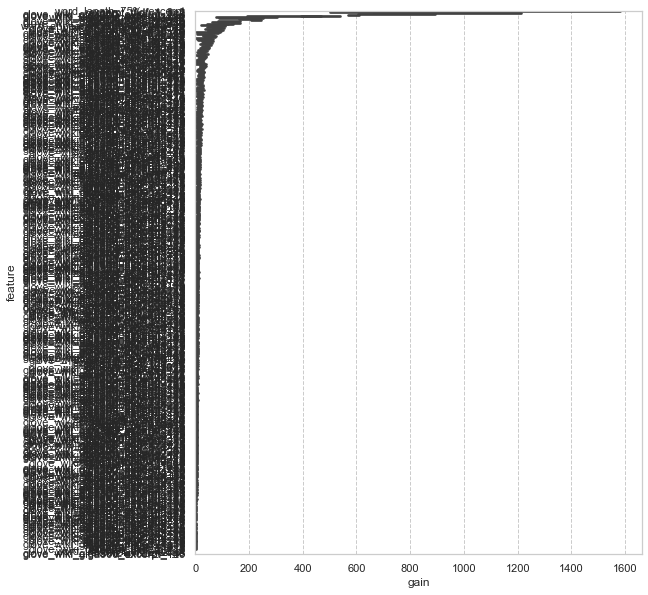

In [206]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

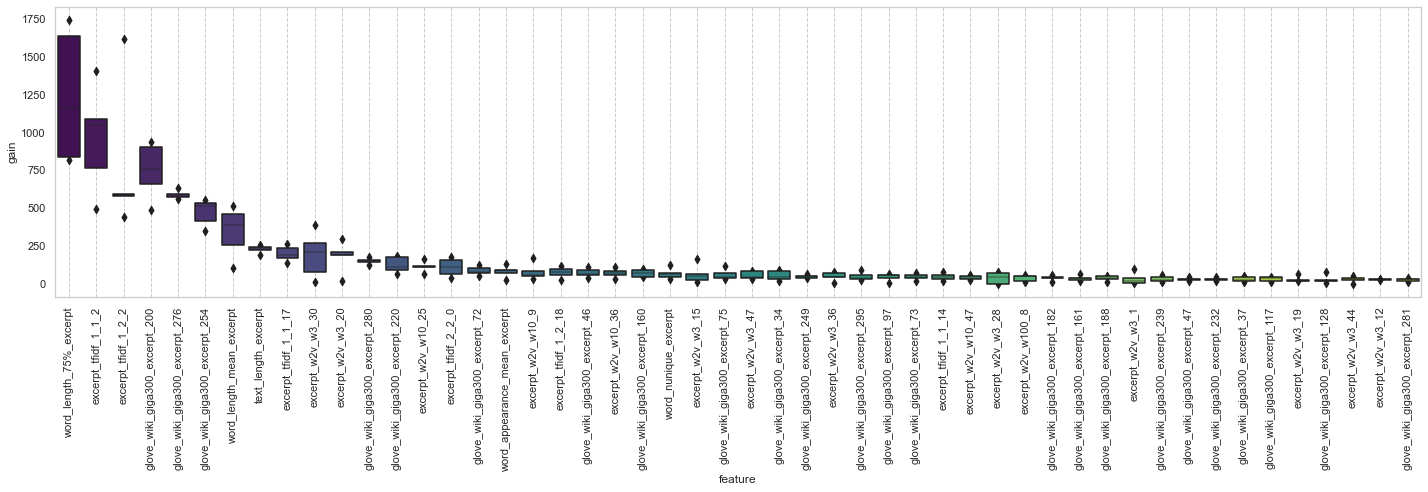

In [207]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [208]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

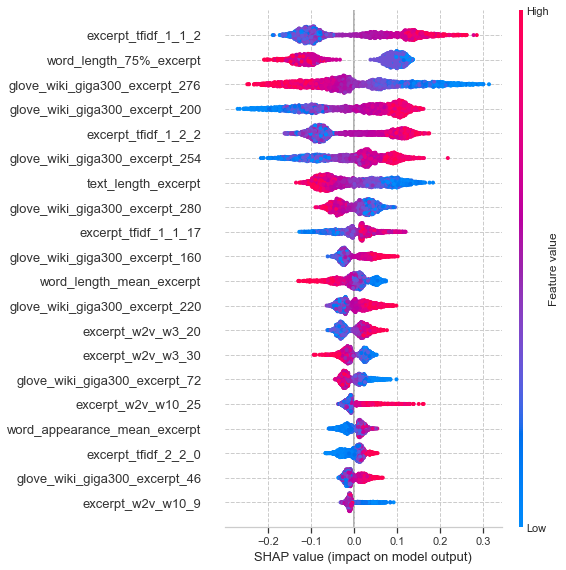

In [209]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

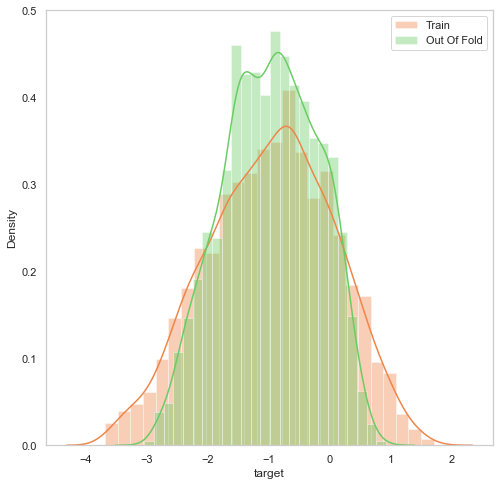

In [210]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))